Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
####  Melanoma is a type of skin cancer. It develops from skin cells called melanocytes. There are 2 main types of skin cancer: Non melanoma skin cancer (which includes basal cell skin cancer, squamous cell skin cancer and other rare types) and melanoma skin cancer. This dataset got 9 types of skin cancer categorise. Images are stored in a seperate folder for Train and Test. Dataset is stored in google drive as folders "Skin_cancer_Images" .
Data structure:
/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection
* Skin_cancer_Images
    * Train
        * actinic keratosis
        * basal cell carcinoma
        * dermatofibroma
        * melanoma
        * nevus
        * pigmented benign keratosis
        * seborrheic keratosis
        * squamous cell carcinoma
        * vascular lesion
    * Test
        * actinic keratosis
        * basal cell carcinoma
        * dermatofibroma
        * melanoma
        * nevus
        * pigmented benign keratosis
        * seborrheic keratosis
        * squamous cell carcinoma
        * vascular lesion


### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Lets mount the dataset from google drive

In [47]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2378 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Remember to store the dataset under UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images in your google drive so thats same can be accessed using "/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images"

In [23]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train")

data_dir_test = pathlib.Path('/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Test')
!ls /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images

Test  Train


In [24]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [25]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

#### Lets Write train dataset with following configs
##### seed 123 as provided requirement
##### validation split 0.2 for 80:20 ratio
##### batch_size, img_height, img_width as per the requirement provided

In [26]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


##### Lets write validation dataset with above mentioned same configurations

In [27]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [28]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


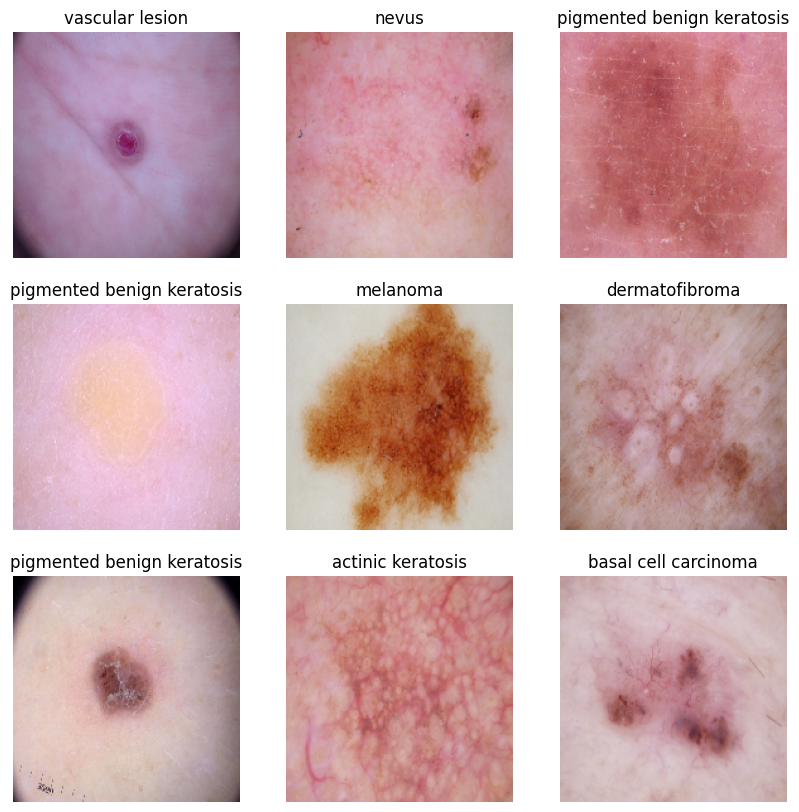

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [31]:

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Lets use Adam optimizer and Crossentropy loss function

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### View the summary of all layers

In [33]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 218s 889ms/step - loss: 2.0202 - accuracy: 0.2294 - val_loss: 1.8849 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.7343 - accuracy: 0.3901 - val_loss: 1.6223 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5270 - accuracy: 0.4604 - val_loss: 1.5088 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4490 - accuracy: 0.4838 - val_loss: 1.5306 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3857 - accuracy: 0.5223 - val_loss: 1.4750 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2528 - accuracy: 0.5631 - val_loss: 1.3802 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1992 - accuracy: 0.5765 - val_loss: 1.4321 - val_accuracy: 0.5145
Epoch 8/20

### Visualizing training results

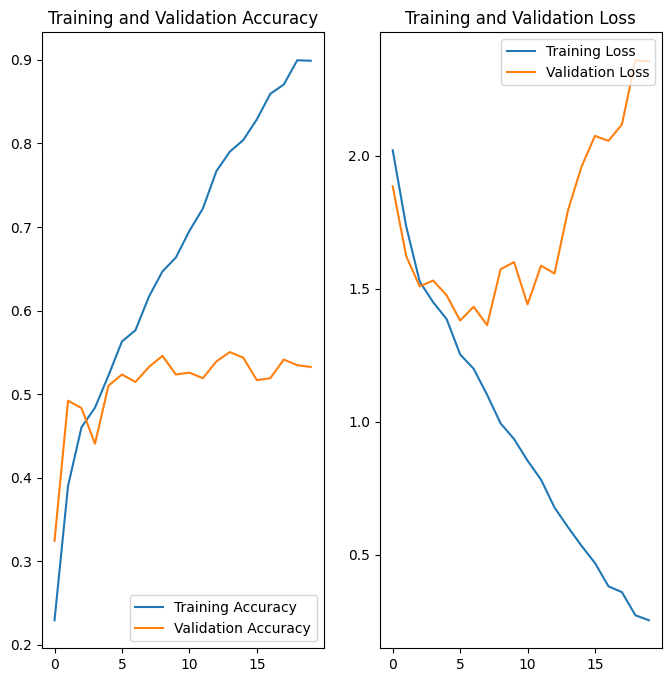

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training Accuracy is much higher than validatin accuracy which leads us to overfitting. Training accuracy is linearly increasing is a sign of overfitting

### Write your findings here

Training accuracy is close to 90% and validation accuracy is close to 54%. So lets take this as overfitting. Lets do rotate and flip the images for better training, I mean augmentation .

In [36]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#### Lets take one image and visualize and see how augmentation changed the image

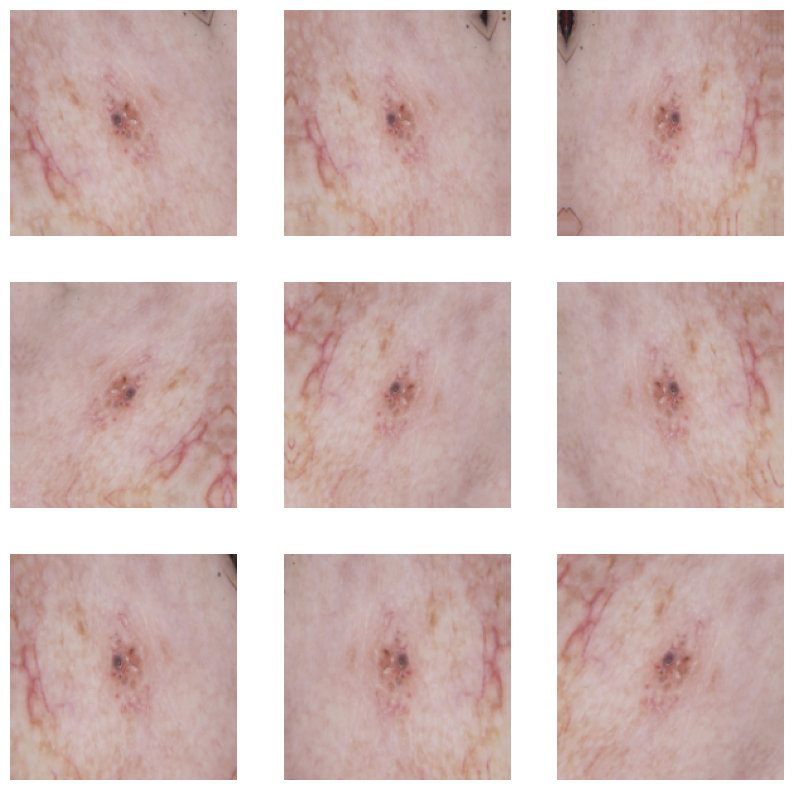

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Lets create model and compile once again to see the effect of augmentation
### Create the model, compile and train the model


In [38]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [40]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 34ms/step - loss: 2.0306 - accuracy: 0.2533 - val_loss: 1.8436 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6583 - accuracy: 0.4062 - val_loss: 1.5900 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4977 - accuracy: 0.4654 - val_loss: 1.5779 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3928 - accuracy: 0.5106 - val_loss: 1.4297 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.3280 - accuracy: 0.5218 - val_loss: 1.3813 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2629 - accuracy: 0.5547 - val_loss: 1.2973 - val_accuracy: 0.5660
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.2443 - accuracy: 0.5513 - val_loss: 1.3333 - val_accuracy: 0.5391
Epoch 8/20
56

### Visualizing the results

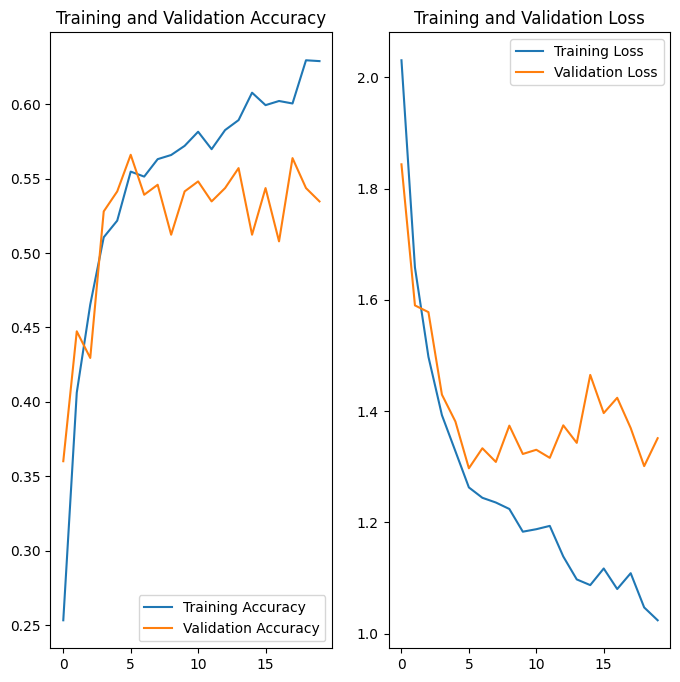

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

By looking at the plot we can say that difference between training accuracy and validation accuracy is reduced though still its over fitting in slight margin.
Training accuracy ~63% and Validation accuracy ~53% , which was ~90% and ~54% respectivly before augmentation.

#### Lets Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [42]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [43]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,melanoma
1,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,melanoma
2,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,melanoma
3,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,melanoma
4,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,melanoma
...,...,...
2234,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,dermatofibroma
2235,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,dermatofibroma
2236,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,dermatofibroma
2237,/content/gdrive/MyDrive/UpGrad/Assignments/Mel...,dermatofibroma


#### Lets find out the number of images in each class, like
1. Which class has the least number of samples?
1. Which classes dominate the data in terms proportionate number of samples?


Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


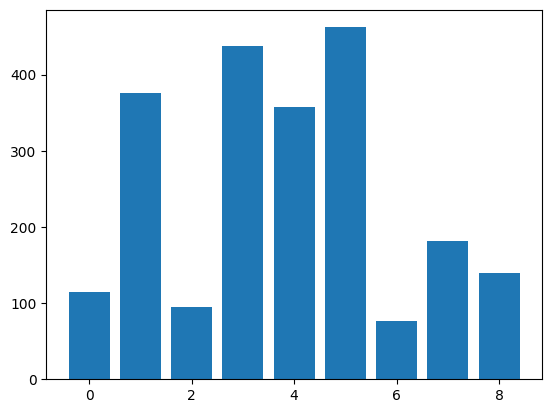

In [44]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

From the above plot its clear that class6 and class2 got relativly very less number of images in training dataset. Sameway class3 and class5 got relatively very high number of images in training dataset.

#### Lets Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [45]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [48]:
path_to_training_dataset="/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AE667E4B550>: 100%|██████████| 500/500 [00:18<00:00, 26.59 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE786802050>: 100%|██████████| 500/500 [00:18<00:00, 26.66 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AE667C22DA0>: 100%|██████████| 500/500 [00:18<00:00, 26.61 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AE666FC26E0>: 100%|██████████| 500/500 [01:37<00:00,  5.13 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE70363FFD0>: 100%|██████████| 500/500 [01:15<00:00,  6.60 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE6AB943850>: 100%|██████████| 500/500 [00:19<00:00, 25.83 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AE61C520C70>: 100%|██████████| 500/500 [00:43<00:00, 11.40 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE6AB925ED0>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AE6FBFB1F60>: 100%|██████████| 500/500 [00:19<00:00, 25.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_22906c85-1b53-472d-99e3-d558ea3c0eb0.jpg',
 '/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0000174.jpg_292b1177-c5c7-4cc2-845f-49a82762b3e5.jpg',
 '/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010225.jpg_89ef9b20-d506-4e62-b3ca-30b3a308197b.jpg',
 '/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0010207.jpg_a33c1c31-ec06-45a8-9a42-ae689d98f6d0.jpg',
 '/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/melanoma/output/melanoma_original_ISIC_0000280.jpg_9f2e9289-6351-4b10-a710-d8c36af03086.jpg',
 '/content/gdrive/MyDrive/UpGrad/Assignments/Melnoma_detection/Skin_cancer_Images/Train/me

In [51]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [56]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [57]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-57-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [58]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Lets Train the model again on the data created using Augmentor

In [59]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [60]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [61]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Lets Create model with same layer and normalisation

In [62]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [70]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train model

In [71]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 6s 28ms/step - loss: 0.0902 - accuracy: 0.9588 - val_loss: 1.0612 - val_accuracy: 0.8434
Epoch 2/30
169/169 [==============================] - 5s 27ms/step - loss: 0.1017 - accuracy: 0.9529 - val_loss: 1.3721 - val_accuracy: 0.7892
Epoch 3/30
169/169 [==============================] - 4s 26ms/step - loss: 0.1180 - accuracy: 0.9522 - val_loss: 1.0670 - val_accuracy: 0.8315
Epoch 4/30
169/169 [==============================] - 4s 26ms/step - loss: 0.0926 - accuracy: 0.9577 - val_loss: 1.1006 - val_accuracy: 0.8367
Epoch 5/30
169/169 [==============================] - 5s 27ms/step - loss: 0.0724 - accuracy: 0.9644 - val_loss: 1.1148 - val_accuracy: 0.8344
Epoch 6/30
169/169 [==============================] - 4s 26ms/step - loss: 0.0737 - accuracy: 0.9644 - val_loss: 1.1093 - val_accuracy: 0.8330
Epoch 7/30
169/169 [==============================] - 4s 26ms/step - loss: 0.0718 - accuracy: 0.9638 - val_loss: 1.0902 - val_accuracy: 0.8367

####  Visualize the model results

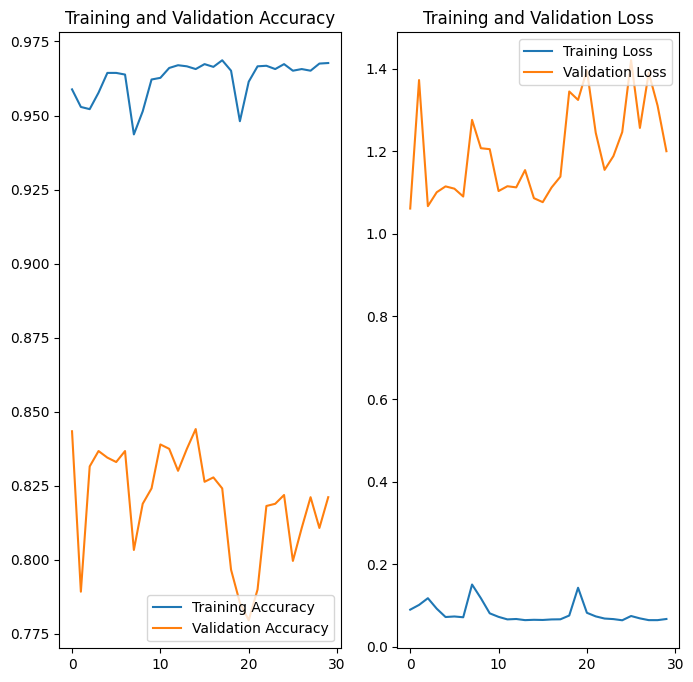

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training accuracy is close to ~96% and Validation accuracy is close to ~84% which shows significant increase in validation accuracy. This is a good sign for the model. Difference between training and validation accuracy reduced so that sounds class rebalance helped to get good model.